In [1]:
import equinox as eqx
# from hypermagnetics.models.hyper_fourier import FourierModel
from hypermagnetics.models.hyper_mlp import HyperLayer

config = {
    "width": 400,
    "depth": 3,
    "hwidth": 1.5,
    "hdepth": 3,
    "seed": 42
}

model_orig = HyperLayer(
    width=config["width"],
    depth=config["depth"],
    hwidth=config["hwidth"],
    hdepth=config["hdepth"],
    seed=config["seed"],
)

filename = "/home/spol/Documents/repos/hypermagnetics/models/ic_inr_400_50k_fcinr_lim_uniform.eqx"
model = eqx.tree_deserialise_leaves(filename, model_orig)

2024-07-01 17:08:13.255278: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
from hypermagnetics import plots
from hypermagnetics.sources import configure
from hypermagnetics.measures import loss, accuracy, accuracy_field

source_config = {
    "shape": "prism",
    "n_samples": 1,
    "lim": 1.2,
    "res": 100,
    "dim": 3,
    "save_data": False,
}
val = configure(**source_config, n_sources=10, seed=101)
print(loss(model, val), accuracy(model, val), accuracy_field(model, val))

0.14979537 6.472306 25.175743


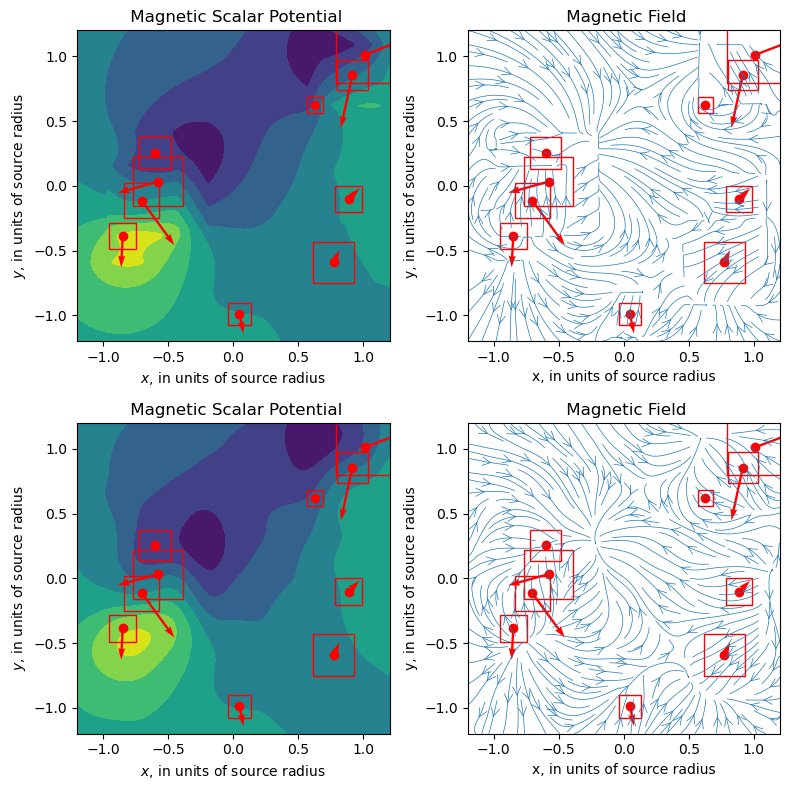

In [3]:
plots(val, idx=0, model=model)

Number of sources: 116
Potential Acc.: 13.668086051940918, Field Acc.: 46.96104049682617


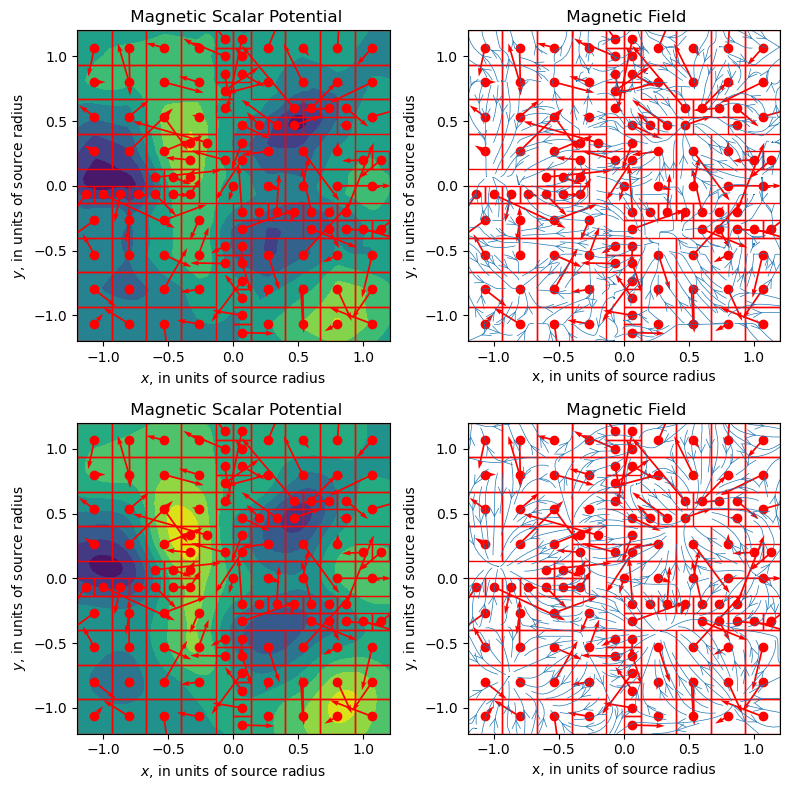

Number of sources: 97
Potential Acc.: 14.373003005981445, Field Acc.: 47.195556640625


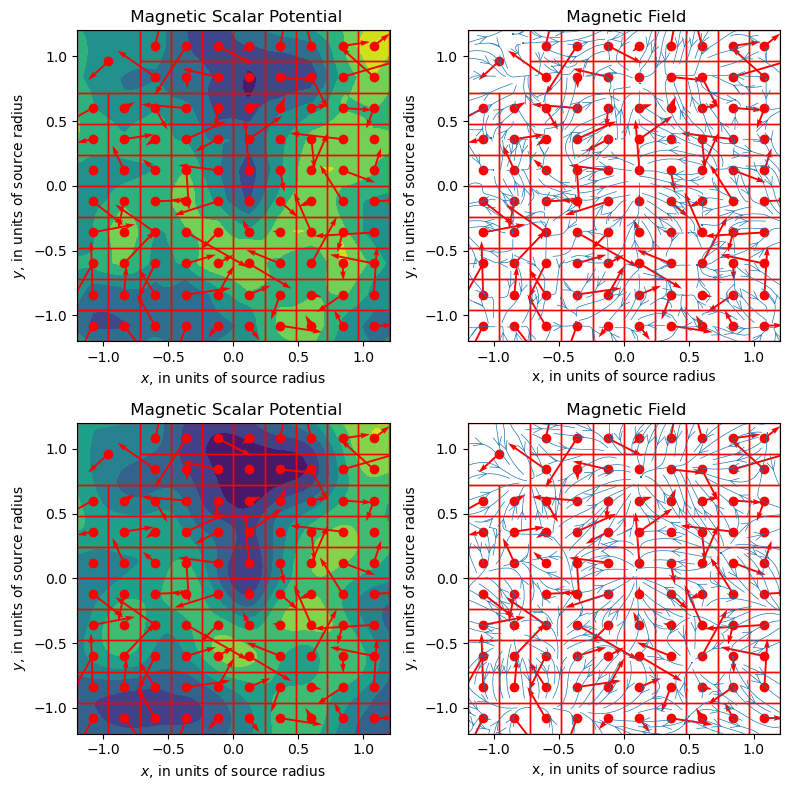

Number of sources: 112
Potential Acc.: 9.37309455871582, Field Acc.: 43.94769287109375


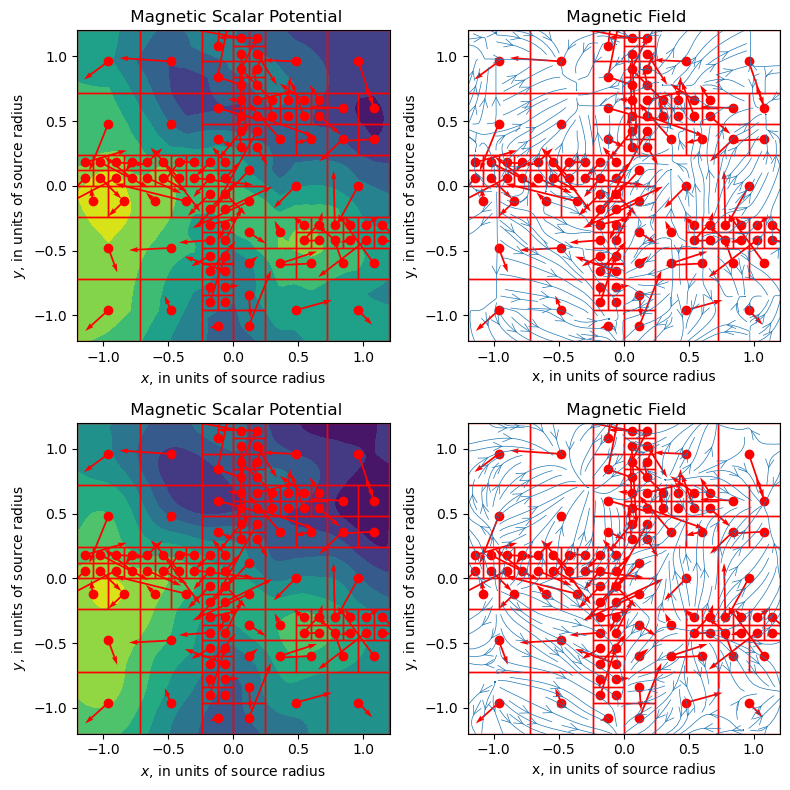

Number of sources: 73
Potential Acc.: 7.732695579528809, Field Acc.: 38.46753692626953


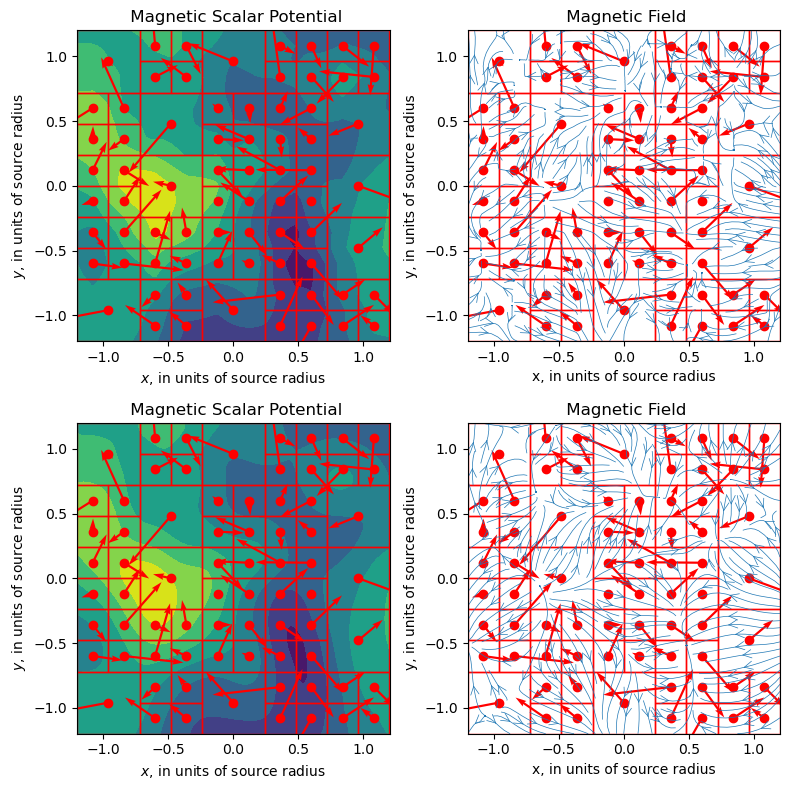

Number of sources: 49
Potential Acc.: 20.00950050354004, Field Acc.: 47.735382080078125


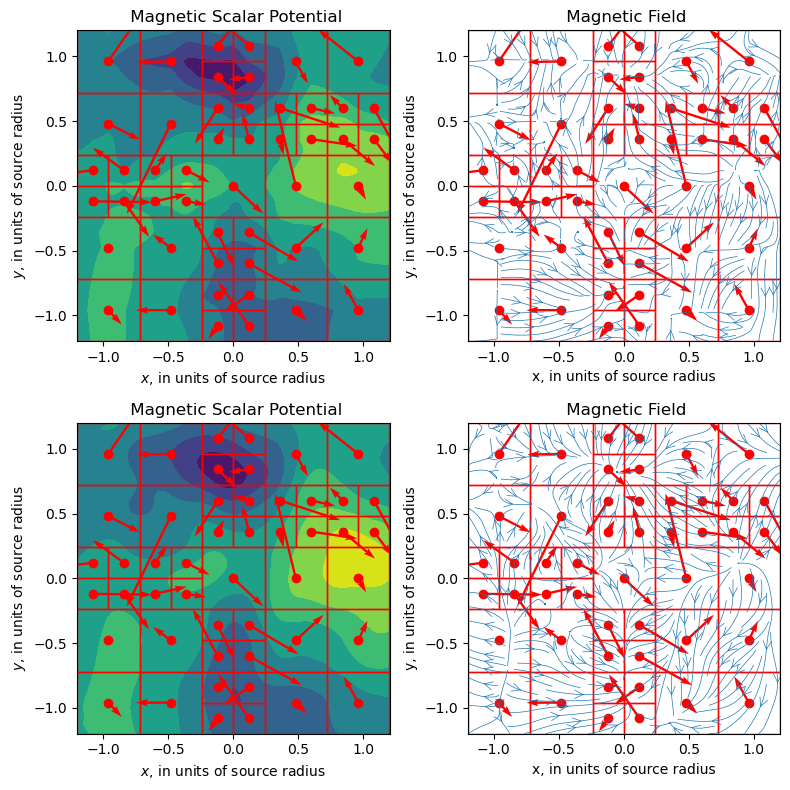

Number of sources: 201
Potential Acc.: 19.73526382446289, Field Acc.: 56.04523849487305


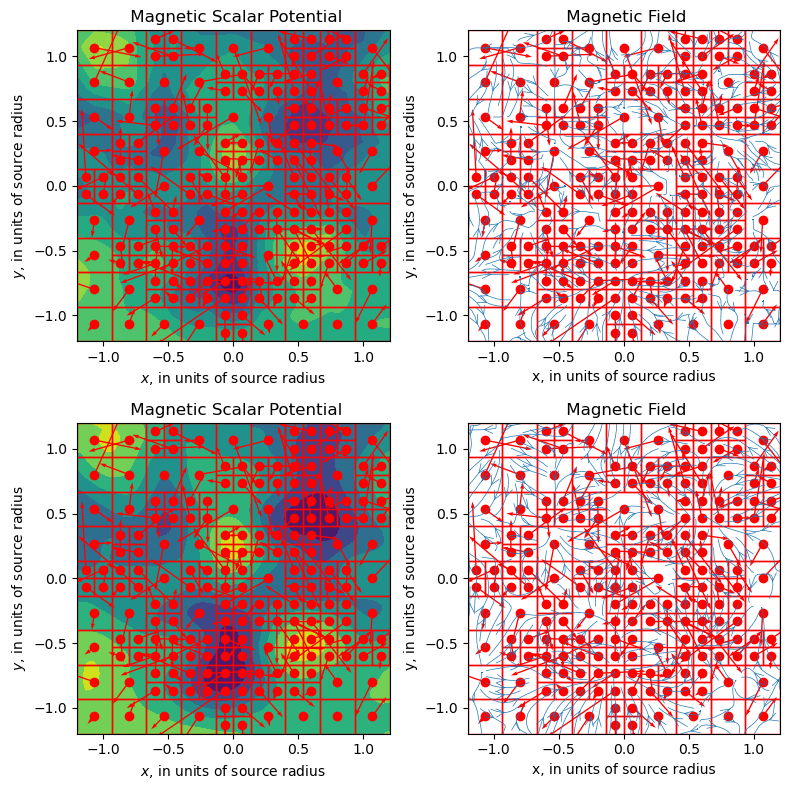

Number of sources: 142
Potential Acc.: 15.760724067687988, Field Acc.: 49.875160217285156


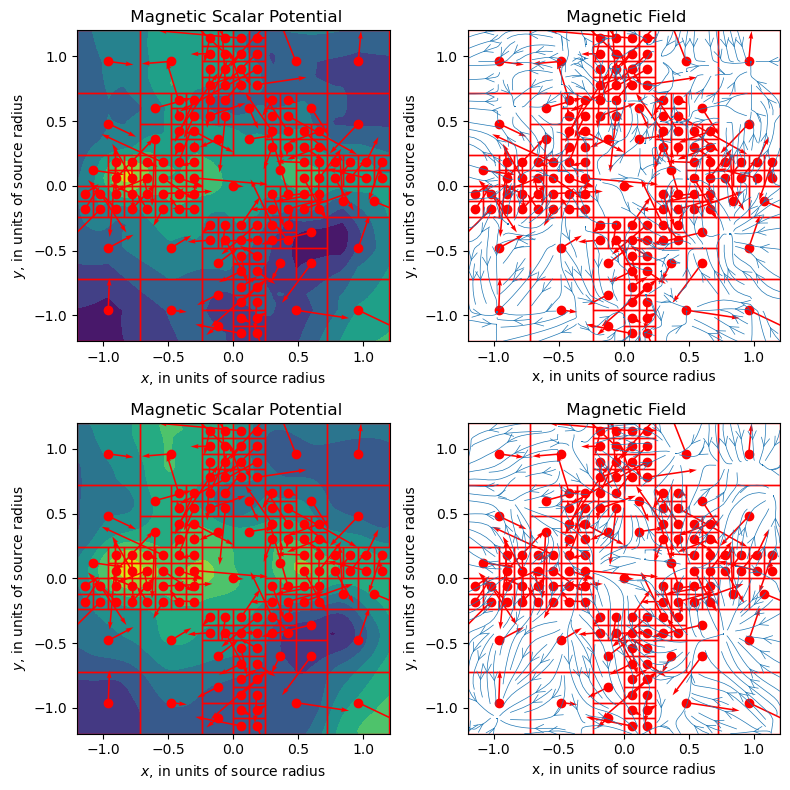

Number of sources: 67
Potential Acc.: 7.52839469909668, Field Acc.: 37.22490692138672


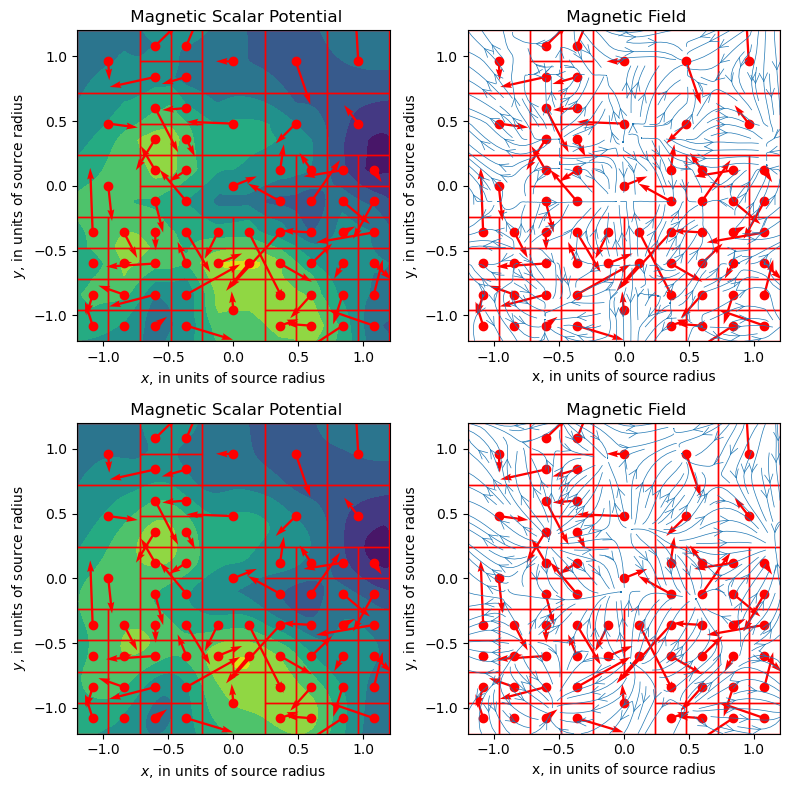

Number of sources: 52
Potential Acc.: 8.861071586608887, Field Acc.: 38.57472610473633


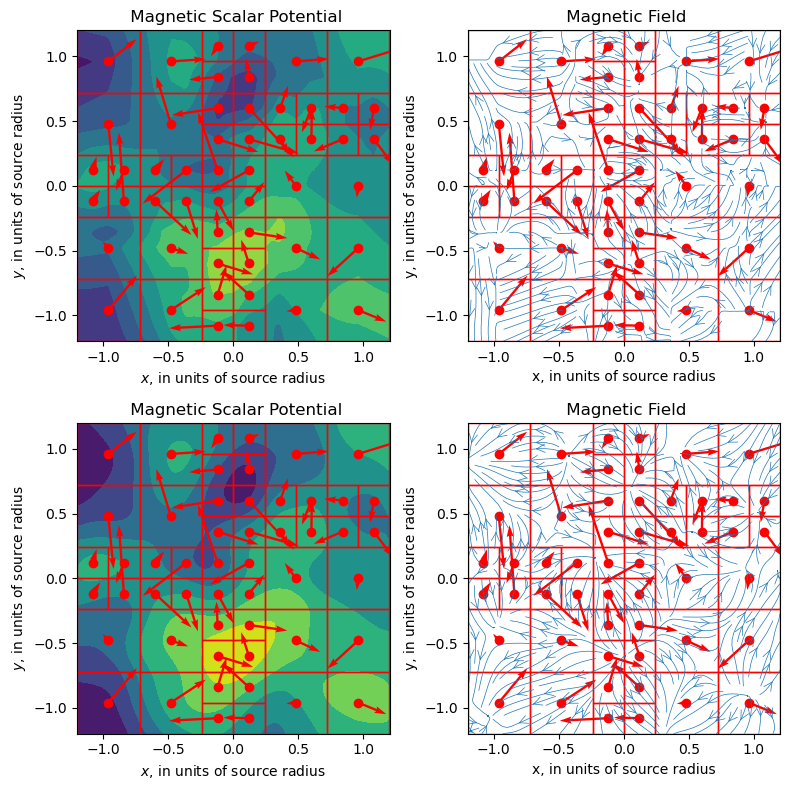

Number of sources: 78
Potential Acc.: 8.235060691833496, Field Acc.: 36.334041595458984


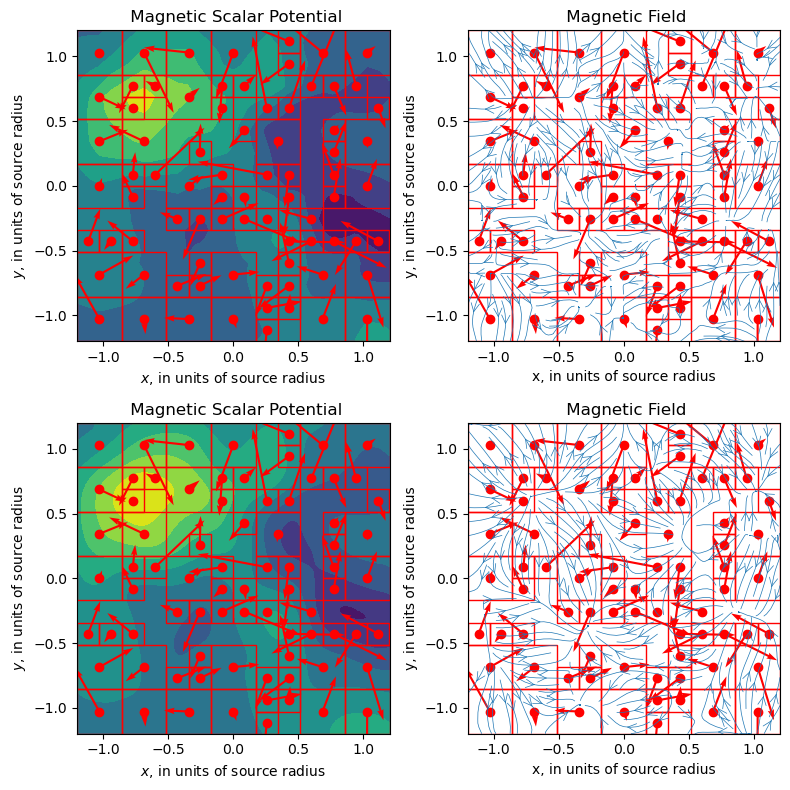

In [4]:
# Shape from Rasmus with minimum size of 0.25
from hypermagnetics.sources import configure, read_db
from hypermagnetics import plots

for file_idx in range(10):
    test = read_db(f"squares_1_{file_idx}.h5")
    print("Number of sources: " + str(test["sources"][:].shape[1]))
    print(f"Potential Acc.: {accuracy(model, test)}, Field Acc.: {accuracy_field(model, test)}")
    plots(test, idx=0, model=model)

In [8]:
from hypermagnetics.sources import configure, read_db
test_idx = 0
test = read_db(f"squares_1_{test_idx}.h5")

In [9]:
import jax
import jax.numpy as jnp

mr = test["sources"][0 :1]
m, r0, size = jnp.split(mr, 3, axis=-1)
grid = test["grid"]

res = int(jnp.sqrt(len(grid)))
N = len(mr)
field_model = jax.vmap(model.field, in_axes=(0, None))(mr, test["grid"])

In [12]:
from hypermagnetics.sources import _field_mt

field_mt, _ = _field_mt(test["sources"], test["grid"], "prism")

In [13]:
sources, r, target = test["sources"], test["r"], test["field_grid"]
diff_mt = target[..., :2] - field_mt[..., :2] * jnp.pi**2
diff_model = target[..., :2] - field_model[..., :2]

for diff in [diff_mt, diff_model]:
    acc = jnp.linalg.norm(diff, axis=-1) / jnp.linalg.norm(target[..., :2], axis=-1) * 100
    # acc = replace_inf_nan(acc)
    print(jnp.median(acc))

0.00021195042
46.465645
